In [2]:
import numpy as np

def compute_cost(split, venues, order_size, lambda_over, lambda_under, theta_queue):
    executed = 0
    cash_spent = 0
    for i in range(len(venues)):
        exe = min(split[i], venues[i]['ask_size'])
        executed += exe
        cash_spent += exe * (venues[i]['ask'] + venues[i]['fee'])
        maker_rebate = max(split[i] - exe, 0) * venues[i]['rebate']
        cash_spent -= maker_rebate

    underfill = max(order_size - executed, 0)
    overfill = max(executed - order_size, 0)
    risk_pen = theta_queue * (underfill + overfill)
    cost_pen = lambda_under * underfill + lambda_over * overfill

    return cash_spent + risk_pen + cost_pen

def allocate(order_size, venues, lambda_over, lambda_under, theta_queue, step=100):
    splits = [[]]  # start with an empty allocation list
    for v in range(len(venues)):
        new_splits = []
        for alloc in splits:
            used = sum(alloc)
            max_v = min(order_size - used, venues[v]['ask_size'])
            for q in range(0, int(max_v) + 1, step):
                new_splits.append(alloc + [q])
        splits = new_splits

    best_cost = float('inf')
    best_split = []
    for alloc in splits:
        if sum(alloc) != order_size:
            continue
        cost = compute_cost(alloc, venues, order_size, lambda_over, lambda_under, theta_queue)
        if cost < best_cost:
            best_cost = cost
            best_split = alloc

    return best_split, best_cost

In [4]:
import pandas as pd

# === STEP 1: Preprocess l1_day.csv into time-ordered snapshots ===
# Load data
df = pd.read_csv("l1_day.csv")

# Keep only first message per publisher_id per ts_event
df = df.sort_values(["ts_event", "publisher_id"])
df = df.drop_duplicates(subset=["ts_event", "publisher_id"], keep="first")

# Group by ts_event to build list of snapshots
snapshots = []
for ts, group in df.groupby("ts_event"):
    snapshot = []
    for _, row in group.iterrows():
        venue = {
            "ask": row["ask_px_00"],
            "ask_size": row["ask_sz_00"],
            "fee": 0.01,       # assumed constant
            "rebate": 0.002    # assumed constant
        }
        snapshot.append(venue)
    snapshots.append(snapshot)

# === STEP 3: Define backtest engine for one parameter set ===
def backtest(snapshots, order_size, lambda_over, lambda_under, theta_queue):
    total_cost = 0
    shares_remaining = order_size

    for snapshot in snapshots:
        if shares_remaining <= 0:
            break

        alloc, cost = allocate(
            order_size=shares_remaining,
            venues=snapshot,
            lambda_over=lambda_over,
            lambda_under=lambda_under,
            theta_queue=theta_queue,
            step=100
        )

        if not alloc:
            continue  # skip if allocator returned nothing (e.g., infeasible snapshot)

        # Execute based on allocator output and available ask sizes
        executed = 0
        cash_spent = 0
        for i in range(len(snapshot)):
            fill = min(alloc[i], snapshot[i]["ask_size"])
            executed += fill
            cash_spent += fill * (snapshot[i]["ask"] + snapshot[i]["fee"])
            rebate = max(alloc[i] - fill, 0) * snapshot[i]["rebate"]
            cash_spent -= rebate

        total_cost += cash_spent
        shares_remaining -= executed

    shares_filled = order_size - shares_remaining
    avg_price = total_cost / shares_filled if shares_filled > 0 else float("inf")

    return {
        "total_cash": round(total_cost, 2),
        "avg_price": round(avg_price, 4),
        "shares_filled": shares_filled
    }

# Example run for a single parameter set
example_result = backtest(snapshots, order_size=5000,
                          lambda_over=1.0, lambda_under=1.0, theta_queue=0.001)

example_result


{'total_cash': 1113750.0, 'avg_price': 222.75, 'shares_filled': 5000}

In [5]:
# === STEP 4: Grid Search for Best Parameters ===

# Define grid
lambda_over_grid = [0.1, 1.0, 10.0]
lambda_under_grid = [0.1, 1.0, 10.0]
theta_queue_grid = [0.001, 0.01, 0.1]

# Track best result
best_result = None
best_params = None

# Perform grid search
for lo in lambda_over_grid:
    for lu in lambda_under_grid:
        for tq in theta_queue_grid:
            result = backtest(snapshots, order_size=5000,
                              lambda_over=lo, lambda_under=lu, theta_queue=tq)

            if best_result is None or result["total_cash"] < best_result["total_cash"]:
                best_result = result
                best_params = {"lambda_over": lo, "lambda_under": lu, "theta_queue": tq}

# Combine best params and result for display
best_overall = {
    "best_parameters": best_params,
    "smart_order_router": best_result
}

best_overall

{'best_parameters': {'lambda_over': 0.1,
  'lambda_under': 0.1,
  'theta_queue': 0.001},
 'smart_order_router': {'total_cash': 1113750.0,
  'avg_price': 222.75,
  'shares_filled': 5000}}

In [7]:
def best_ask_baseline(snapshots, order_size):
    remaining = order_size
    total_cost = 0

    for snapshot in snapshots:
        if remaining <= 0:
            break
        # Find the venue with the lowest ask
        best_venue = min(snapshot, key=lambda v: v['ask'])
        fill = min(best_venue['ask_size'], remaining)
        total_cost += fill * (best_venue['ask'] + best_venue['fee'])
        remaining -= fill

    filled = order_size - remaining
    avg_price = total_cost / filled if filled > 0 else float("inf")
    return {"total_cash": round(total_cost, 2), "avg_price": round(avg_price, 4), "shares_filled": filled}


def twap_baseline(snapshots, order_size, bucket_seconds=60):
    df = pd.read_csv("l1_day.csv")
    df = df.sort_values(["ts_event", "publisher_id"])
    df = df.drop_duplicates(subset=["ts_event", "publisher_id"], keep="first")
    df['ts_event'] = pd.to_datetime(df['ts_event'], unit='ns')
    df.set_index("ts_event", inplace=True)
    
    # Determine time buckets
    start = df.index.min()
    end = df.index.max()
    duration = (end - start).total_seconds()
    num_buckets = int(duration // bucket_seconds) + 1
    chunk_size = order_size // num_buckets

    remaining = order_size
    total_cost = 0

    for i in range(num_buckets):
        bucket_start = start + pd.Timedelta(seconds=i * bucket_seconds)
        bucket_end = bucket_start + pd.Timedelta(seconds=bucket_seconds)
        bucket_df = df[bucket_start:bucket_end]

        if bucket_df.empty or remaining <= 0:
            continue

        snapshot = []
        for pid, row in bucket_df.drop_duplicates('publisher_id').iterrows():
            snapshot.append({
                "ask": row["ask_px_00"],
                "ask_size": row["ask_sz_00"],
                "fee": 0.01,
                "rebate": 0.002
            })

        # Buy from best price in this bucket
        chunk = min(chunk_size, remaining)
        filled = 0
        cost = 0
        for venue in sorted(snapshot, key=lambda v: v["ask"]):
            fill = min(venue["ask_size"], chunk - filled)
            cost += fill * (venue["ask"] + venue["fee"])
            filled += fill
            if filled >= chunk:
                break

        total_cost += cost
        remaining -= filled

    filled = order_size - remaining
    avg_price = total_cost / filled if filled > 0 else float("inf")
    return {"total_cash": round(total_cost, 2), "avg_price": round(avg_price, 4), "shares_filled": filled}


def vwap_baseline(snapshots, order_size):
    remaining = order_size
    total_cost = 0

    for snapshot in snapshots:
        if remaining <= 0:
            break
        total_liquidity = sum(v['ask_size'] for v in snapshot)
        if total_liquidity == 0:
            continue
        for venue in snapshot:
            weight = venue['ask_size'] / total_liquidity
            to_buy = min(weight * remaining, venue['ask_size'])
            total_cost += to_buy * (venue['ask'] + venue['fee'])
            remaining -= to_buy
            if remaining <= 0:
                break

    filled = order_size - remaining
    avg_price = total_cost / filled if filled > 0 else float("inf")
    return {"total_cash": round(total_cost, 2), "avg_price": round(avg_price, 4), "shares_filled": filled}

# Run all three baselines
bestask_result = best_ask_baseline(snapshots, order_size=5000)
twap_result = twap_baseline(snapshots, order_size=5000)
vwap_result = vwap_baseline(snapshots, order_size=5000)

bestask_result, twap_result, vwap_result

({'total_cash': 1114152.28, 'avg_price': 222.8305, 'shares_filled': 5000},
 {'total_cash': 444862.12, 'avg_price': 223.1004, 'shares_filled': 1994},
 {'total_cash': 1114152.28, 'avg_price': 222.8305, 'shares_filled': 5000.0})

In [8]:
def compute_bps_saving(baseline_price, ck_price):
    return round((baseline_price - ck_price) / baseline_price * 10_000, 2)

# Compute savings in bps
bps_bestask = compute_bps_saving(bestask_result["avg_price"], best_overall["smart_order_router"]["avg_price"])
bps_twap = compute_bps_saving(twap_result["avg_price"], best_overall["smart_order_router"]["avg_price"])
bps_vwap = compute_bps_saving(vwap_result["avg_price"], best_overall["smart_order_router"]["avg_price"])

bps_bestask, bps_twap, bps_vwap

(3.61, 15.71, 3.61)

{
  "best_parameters": {
    "lambda_over": 0.1,
    "lambda_under": 0.1,
    "theta_queue": 0.001
  },
  "smart_order_router": {
    "total_cash": 1113750.0,
    "avg_price": 222.75,
    "shares_filled": 5000
  },
  "best_ask": {
    "total_cash": 1114152.28,
    "avg_price": 222.8305,
    "shares_filled": 5000,
    "saving_bps": 3.61
  },
  "twap": {
    "total_cash": 444862.12,
    "avg_price": 223.1004,
    "shares_filled": 1994,
    "saving_bps": 15.71
  },
  "vwap": {
    "total_cash": 1114152.28,
    "avg_price": 222.8305,
    "shares_filled": 5000.0,
    "saving_bps": 3.61
  }
}


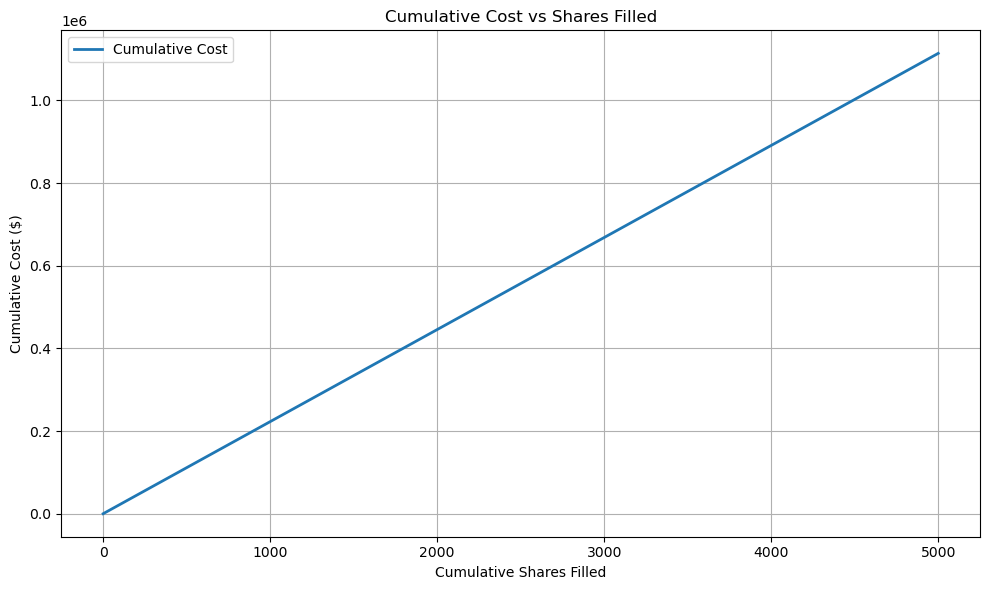

In [10]:
import json
import matplotlib.pyplot as plt

# === STEP 7: Final JSON Output ===
final_output = {
    "best_parameters": best_overall["best_parameters"],
    "smart_order_router": best_overall["smart_order_router"],
    "best_ask": {
        **bestask_result,
        "saving_bps": bps_bestask
    },
    "twap": {
        **twap_result,
        "saving_bps": bps_twap
    },
    "vwap": {
        **vwap_result,
        "saving_bps": bps_vwap
    }
}

# Print the final JSON result to stdout
print(json.dumps(final_output, indent=2))

# === STEP 8: Cumulative Cost Plot ===

def get_cumulative_costs_and_fills(snapshots, order_size, lambda_over, lambda_under, theta_queue, step=10):
    shares_remaining = order_size
    cumulative_cost = []
    cumulative_filled = []
    total_cost = 0
    total_filled = 0

    for snapshot in snapshots:
        if shares_remaining <= 0:
            break

        alloc, _ = allocate(
            order_size=shares_remaining,
            venues=snapshot,
            lambda_over=lambda_over,
            lambda_under=lambda_under,
            theta_queue=theta_queue,
            step=step
        )

        if not alloc:
            cumulative_cost.append(total_cost)
            cumulative_filled.append(total_filled)
            continue

        executed = 0
        cash_spent = 0
        for i in range(len(snapshot)):
            fill = min(alloc[i], snapshot[i]["ask_size"])
            executed += fill
            cash_spent += fill * (snapshot[i]["ask"] + snapshot[i]["fee"])
            rebate = max(alloc[i] - fill, 0) * snapshot[i]["rebate"]
            cash_spent -= rebate

        total_cost += cash_spent
        shares_remaining -= executed
        total_filled += executed

        cumulative_cost.append(total_cost)
        cumulative_filled.append(total_filled)

    return cumulative_cost, cumulative_filled

# Run updated cumulative tracking
cum_costs, cum_fills = get_cumulative_costs_and_fills(
    snapshots,
    order_size=5000,
    lambda_over=best_overall["best_parameters"]["lambda_over"],
    lambda_under=best_overall["best_parameters"]["lambda_under"],
    theta_queue=best_overall["best_parameters"]["theta_queue"],
    step=10
)

# Plot: Cumulative cost vs fill progress
plt.figure(figsize=(10, 6))
plt.plot(cum_fills, cum_costs, label="Cumulative Cost", linewidth=2)
plt.xlabel("Cumulative Shares Filled")
plt.ylabel("Cumulative Cost ($)")
plt.title("Cumulative Cost vs Shares Filled")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig("results.png")